In [1]:
# initial setup
try:
    # settings colab:
    import google.colab

    ! mkdir -p ../Data
    # los que usan colab deben modificar el token de esta url:
    ! wget -O ../Data/bikes.csv https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_students_2020/master/M3/CLASE_16_Regresion_Lineal_Multiple/Data/bikes.csv?token=AA4GFHIG665I3BPVQCFY3US63APZM
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed


In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
%matplotlib inline

# Definimos parámetros globales para matplotlib.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16

data_original = pd.read_csv('Clean08_OultiersxZona_Ale_02.csv')

In [3]:
data_original.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,País,Provincia,Área,Localidad,Zona,Lugar,index,...,baulera,piscina_house,piscina_depart,desc_banios,tipo_propiedad_Fondo de Comercio,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store,Outliers
0,0,0,0,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,0,...,0.0,0,0,1.0,0,1,0,0,0,NaN
1,1,1,1,Argentina,Buenos Aires,Zona Sur,La Plata,La Plata,La Plata,1,...,0.0,0,0,1.0,0,0,1,0,0,NaN


In [4]:
data_original.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'País',
       'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'index',
       'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name',
       'geonames_id', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'Operacion_Description',
       'Operacion_Title', 'Operacion_URL', 'url_clean', 'url_terraza',
       'url_quincho', 'desc_terraza', 'desc_quincho', 'garage',
       'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities',
       'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house',
       'piscina_depart', 'desc_banios',
       'tipo_propiedad_Fondo de Comercio', 'tipo_propiedad_PH',
       'tipo_propiedad_apartmen

In [5]:
for c in data_original.columns[3:]:
    if data_original[c].isnull().sum() > 0:
        print(c, " ", data_original[c].isnull().sum())

place_name   22
geonames_id   17559
lat-lon   48510
lat   48510
lon   48510
price   20398
currency   20399
price_aprox_local_currency   20398
price_aprox_usd   24873
surface_total_in_m2   16846
surface_covered_in_m2   20122
price_usd_per_m2   31368
price_per_m2   32816
floor   106759
rooms   62490
expenses   100836
description   2
image_thumbnail   2956
Operacion_Description   73001
Operacion_Title   79702
desc_banios   42327
Outliers   104883


In [6]:
data = data_original.drop(columns=
['Unnamed: 0', 
 'Unnamed: 0.1', 
 'Unnamed: 0.1.1',
 'index',
 'operation', 
 'property_type', 
 'geonames_id', 
 'lat-lon',
 'price',
 'currency',
 'country_name',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'floor', 
 'title', 
 'image_thumbnail', 
 'Operacion_Description',
 'expenses',
 'properati_url',
 'Operacion_Title', 
 'Operacion_URL',
 'url_clean',
 'url_terraza', 
 'url_quincho', 
 'desc_terraza', 
 'desc_quincho',
 'desc_banios',
 'tipo_propiedad_Fondo de Comercio', 
 'Outliers',
 'País',
 'Provincia', 
 'Área', 
 'Localidad', 
 'Zona', 
 'Lugar',
 'place_with_parent_names', 
 'lat', 'lon', 'place_name', 'state_name'])

In [7]:
largo_maximo_zona = data_original.place_with_parent_names.apply(lambda x: len(x[1:len(x) - 1].split("|"))).max()

In [8]:
data_original.place_with_parent_names.apply(lambda x: len(x[1:len(x) - 1].split("|"))).min()

2

In [9]:
def agregar_ubicacion(zona_str, largo_maximo_zona):
    zona_array = zona_str[1:len(zona_str) - 1].split("|")
    largo = len(zona_array)
    if largo < largo_maximo_zona:
        zona_array.extend(np.full(largo_maximo_zona - largo, zona_array[largo - 1]))
    return zona_array

In [10]:
zonas_serie = data_original.place_with_parent_names.apply(lambda x: agregar_ubicacion(x, largo_maximo_zona))

In [11]:
for i in range(largo_maximo_zona):
    data["zona" + str((i + 1))] = zonas_serie.apply(lambda x: x[i])

In [12]:
data.head(2)

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,description,garage,lavadero,balcon,parrilla,jardin,...,piscina_depart,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store,zona1,zona2,zona3,zona4,zona5
0,55.0,40.0,1127.272727,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,Argentina,Capital Federal,Mataderos,Mataderos,Mataderos
1,NaN,NaN,NaN,NaN,Venta de departamento en décimo piso al frente...,1.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,La Plata


In [13]:
#data.lat = np.round(data.lat, 2)
#data.lon = np.round(data.lon, 2)

In [14]:
print(data.rooms.isnull().sum())
regex = re.compile("\d\sambientes", flags = re.IGNORECASE)
regexRooms = data[(data.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambientes", "").strip()).astype(np.float64)
data.loc[resultado.index, "rooms"]  = resultado
print(data.rooms.isnull().sum())

62490
51802


In [15]:
print(data.rooms.isnull().sum())
regex = re.compile("\d\samb", flags = re.IGNORECASE)
regexRooms = data[(data.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" amb", "").strip()).astype(np.float64)
data.loc[resultado.index, "rooms"]  = resultado
print(data.rooms.isnull().sum())

51802
48722


In [16]:
print(data.rooms.isnull().sum())
regex = re.compile("1\sambiente", flags = re.IGNORECASE)
regexRooms = data[(data.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace(" ambiente", "").strip()).astype(np.float64)
data.loc[resultado.index, "rooms"]  = resultado
print(data.rooms.isnull().sum())

48722
48722


In [17]:
print(data.rooms.isnull().sum())
regex = re.compile("un\sambiente", flags = re.IGNORECASE)
regexRooms = data[(data.rooms.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexRooms.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("un ambiente", "1").strip()).astype(np.float64)
data.loc[resultado.index, "rooms"]  = resultado
print(data.rooms.isnull().sum())

48722
48196


In [18]:
data = data.drop(columns=["description"])

In [19]:
data.columns.values

array(['surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin',
       'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera',
       'piscina_house', 'piscina_depart', 'tipo_propiedad_PH',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'zona1', 'zona2', 'zona3', 'zona4',
       'zona5'], dtype=object)

In [20]:
# Elimino nulos
data = data.dropna()
data.isnull().sum()

surface_total_in_m2         0
surface_covered_in_m2       0
price_usd_per_m2            0
rooms                       0
garage                      0
lavadero                    0
balcon                      0
parrilla                    0
jardin                      0
patio                       0
amenities                   0
estrenar                    0
gimnasio                    0
subte                       0
baulera                     0
piscina_house               0
piscina_depart              0
tipo_propiedad_PH           0
tipo_propiedad_apartment    0
tipo_propiedad_house        0
tipo_propiedad_store        0
zona1                       0
zona2                       0
zona3                       0
zona4                       0
zona5                       0
dtype: int64

In [21]:
data.describe()

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,garage,lavadero,balcon,parrilla,jardin,patio,...,estrenar,gimnasio,subte,baulera,piscina_house,piscina_depart,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
count,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,...,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000,47171.000000
mean,107.648322,85.096882,1958.484761,2.858939,0.511119,0.382311,0.448793,0.294503,0.129529,0.181298,...,0.109198,0.096373,0.249687,0.117254,0.056369,0.176761,0.067096,0.724937,0.204787,0.002968
std,108.765275,69.890487,851.669284,1.524580,0.499882,0.485957,0.497376,0.455824,0.335788,0.385269,...,0.311891,0.295105,0.432837,0.321726,0.230636,0.381470,0.250191,0.446551,0.403550,0.054398
min,12.000000,0.000000,19.050136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,42.000000,1375.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,60.000000,1931.910794,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,120.000000,100.000000,2492.572965,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,800.000000,600.000000,5000.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
feature_cols = data.columns.values

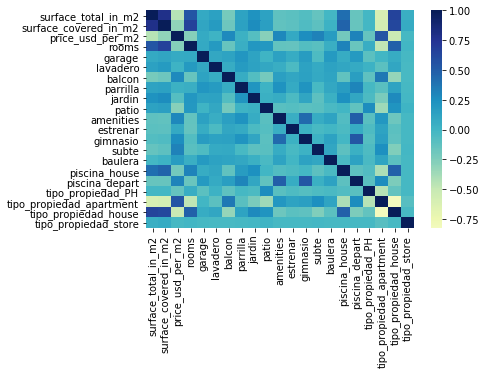

In [23]:
sns.heatmap(data[feature_cols].corr(), center=0, cmap="YlGnBu", annot=False);

In [24]:
#prueba = data_original[data_original.property_type == "apartment"].surface_covered_in_m2 / data_original[data_original.property_type == "apartment"].rooms

In [25]:
data = pd.get_dummies(data, columns=["rooms"], prefix="rooms_", drop_first=True)

In [26]:
#data = pd.get_dummies(data, columns=["lat"], prefix="lat_", drop_first=True)
#data = pd.get_dummies(data, columns=["lon"], prefix="lon_", drop_first=True)

In [27]:
for i in range(largo_maximo_zona):
    data = pd.get_dummies(data, columns=["zona" + str(i + 1)], prefix="z" + str(i + 1) + "_", drop_first=True)

In [28]:
feature_cols = data.columns.values.tolist()
feature_cols.remove('price_usd_per_m2')
predecir = "price_usd_per_m2"

In [29]:
feature_cols[0:20]

['surface_total_in_m2',
 'surface_covered_in_m2',
 'garage',
 'lavadero',
 'balcon',
 'parrilla',
 'jardin',
 'patio',
 'amenities',
 'estrenar',
 'gimnasio',
 'subte',
 'baulera',
 'piscina_house',
 'piscina_depart',
 'tipo_propiedad_PH',
 'tipo_propiedad_apartment',
 'tipo_propiedad_house',
 'tipo_propiedad_store',
 'rooms__1.0']

In [30]:
len(feature_cols)

1810

<hr>

## model_train_test_error_statsmodels

In [31]:
def model_train_test_error_statsmodels(df, feature_cols, columna_predecir):
    X = df[feature_cols]
    y = df[columna_predecir]
    X_constant = sm.add_constant(X)
    modelo = sm.OLS(y, X_constant).fit()
    y_pred = modelo.predict(X_constant)
    print (modelo.summary())
    print ()
    return modelo, y, X_constant, X

In [66]:
modeloOLS, yOLS, X_constant, X = model_train_test_error_statsmodels(
    data, 
    feature_cols, predecir)

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     937.6
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:41:48   Log-Likelihood:            -3.6347e+05
No. Observations:               47171   AIC:                         7.271e+05
Df Residuals:                   47094   BIC:                         7.278e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [64]:
feature_cols = modeloOLS.pvalues[modeloOLS.pvalues <= 0.01].index.values[1:]

In [65]:
len(feature_cols)

160

<hr>

## model_train_test_error

In [35]:
# Esta función recibe el modelo ya instanciado con los hiperparámetros, el dataframe, 
# los nombres de las columnas predictoras y el nombre de la columna que quiero predecir
def model_train_test_error(modelo, df, feature_cols, columna_predecir):
    X = df[feature_cols]
    y = df[columna_predecir]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
    modelo_fit = modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    #print (feature_cols)
    print ("y_test sample: ",y_test.values[0:10])
    print ("y_pred sample: ",y_pred[0:10].astype(int))
    print ('Metrics.MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print ('Metrics.MSE:', metrics.mean_squared_error(y_test, y_pred))
    print ('Metrics.RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('Metrics.R2:', metrics.r2_score(y_test, y_pred))
    print ("Modelo_fit.r^2:", modelo_fit.score(X_test, y_test))    
    print ('Modelo_fit.Score test: ', modelo_fit.score(X_test, y_test))
    print ('Modelo_fit.Score train: ', modelo_fit.score(X_train, y_train))
    #print ("Modelo_fit.coef: ", modelo_fit.coef_)

    if hasattr(modelo, 'alpha_'):    
        print("Alpha: ", modelo_fit.alpha_)

    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()        
        
    print ()
    return

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [2340 1895  -26 3511 1632  929 3012 1593 3486 1612]
Metrics.MAE: 424.1241908817663
Metrics.MSE: 298139.6806319982
Metrics.RMSE: 546.0216851298107
Metrics.R2: 0.5910680781923352
Modelo_fit.r^2: 0.5910680781923352
Modelo_fit.Score test:  0.5910680781923352
Modelo_fit.Score train:  0.6059445231790099


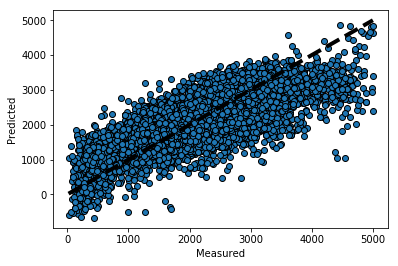

In [36]:
model_train_test_error(
    linear_model.LinearRegression(), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [2308 1876  707 3381 1522 1030 2700 1731 3324 1722]
Metrics.MAE: 440.93869322360877
Metrics.MSE: 322167.13985620835
Metrics.RMSE: 567.5976919052863
Metrics.R2: 0.5581117301614953
Modelo_fit.r^2: 0.5581117301614953
Modelo_fit.Score test:  0.5581117301614953
Modelo_fit.Score train:  0.5750572612096174


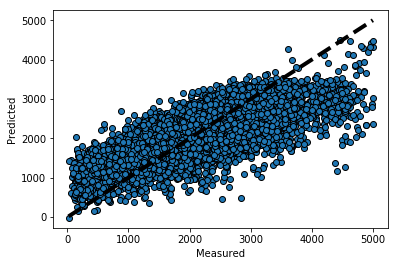

In [37]:
model_train_test_error(
    linear_model.Ridge(alpha=0.5, normalize=True), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [2233 1861  518 2622 1595 1189 2688 1856 2863 1790]
Metrics.MAE: 502.81529487163783
Metrics.MSE: 424034.54878370004
Metrics.RMSE: 651.1793522399954
Metrics.R2: 0.4183891839577091
Modelo_fit.r^2: 0.4183891839577091
Modelo_fit.Score test:  0.4183891839577091
Modelo_fit.Score train:  0.4349961548321793


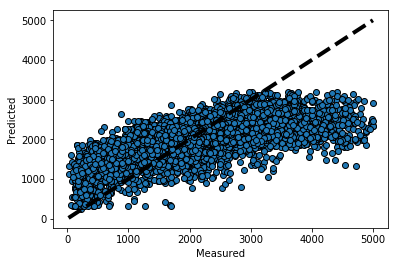

In [38]:
model_train_test_error(
    linear_model.Lasso(alpha=0.5, normalize=True), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [1953 1953 1953 1954 1953 1953 1953 1953 1954 1953]
Metrics.MAE: 672.6886217254947
Metrics.MSE: 729141.2207564822
Metrics.RMSE: 853.8976641006124
Metrics.R2: -9.874579953428331e-05
Modelo_fit.r^2: -9.874579953428331e-05
Modelo_fit.Score test:  -9.874579953428331e-05
Modelo_fit.Score train:  0.0002747662001727491


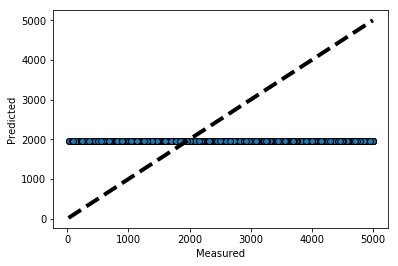

In [39]:
model_train_test_error(
    linear_model.ElasticNet(alpha=0.5, normalize=True), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [2339 1893   13 3511 1625  925 3003 1599 3483 1617]
Metrics.MAE: 424.25741637289593
Metrics.MSE: 298393.14009257505
Metrics.RMSE: 546.2537323374322
Metrics.R2: 0.59072043019025
Modelo_fit.r^2: 0.59072043019025
Modelo_fit.Score test:  0.59072043019025
Modelo_fit.Score train:  0.6058878195729209
Alpha:  0.01


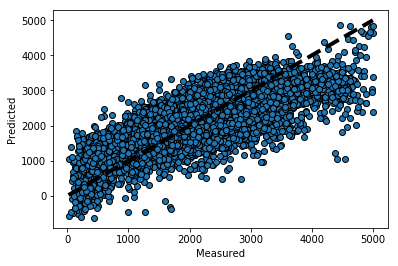

In [62]:
model_train_test_error(
    linear_model.RidgeCV(alphas=np.linspace(0.01, 10, 20), cv=3, normalize=True,scoring='r2'), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [2336 1893  -10 3497 1623  930 3010 1597 3477 1622]
Metrics.MAE: 424.42582642651683
Metrics.MSE: 298394.9500438892
Metrics.RMSE: 546.2553890296088
Metrics.R2: 0.5907179476395619
Modelo_fit.r^2: 0.5907179476395619
Modelo_fit.Score test:  0.5907179476395619
Modelo_fit.Score train:  0.6054874045226013
Alpha:  0.01


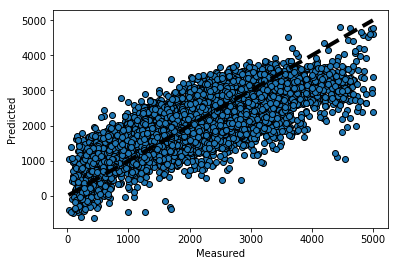

In [41]:
model_train_test_error(
    linear_model.LassoCV(alphas=np.linspace(0.01, 100, 100), cv=3, normalize=True), 
    data, 
    feature_cols, predecir)

y_test sample:  [2777.77777778 2559.52380952  381.3559322  3139.53488372 2000.
 1686.2170088  2323.94366197 2241.37931034 2910.71428571 1430.69155914]
y_pred sample:  [1962 1952 1929 1986 1941 1936 1962 1951 1986 1949]
Metrics.MAE: 666.4793903987085
Metrics.MSE: 715893.0075388376
Metrics.RMSE: 846.1046079172703
Metrics.R2: 0.018072660569872223
Modelo_fit.r^2: 0.018072660569872223
Modelo_fit.Score test:  0.018072660569872223
Modelo_fit.Score train:  0.018964437831077263
Alpha:  0.01


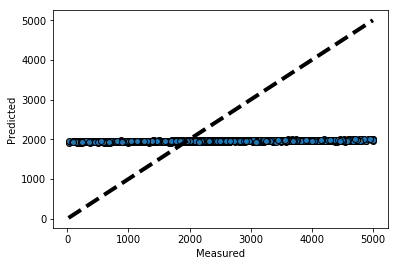

In [42]:
model_train_test_error(
    linear_model.ElasticNetCV(alphas=np.linspace(0.01, 100, 100), cv=3, normalize=True), 
    data, 
    feature_cols, predecir)

<hr>

## model_train_test_error_CrossVal

In [43]:
def model_train_test_error_CrossVal(modelo, df, feature_cols, columna_predecir):
    X = df[feature_cols]
    y = df[columna_predecir]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
    modelo_fit = modelo.fit(X_train, y_train)
    cv = model_selection.KFold(5, shuffle=False)
    scores = model_selection.cross_val_score(modelo, X_train, y_train, cv=cv, scoring='r2')

    if hasattr(modelo, 'alpha_'):
        print(dict(alpha=modelo.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(modelo.coef_ == 0).sum()))
    else:
        print("scores: ", scores)
        print("media de scores", scores.mean())
    return 

In [44]:
model_train_test_error_CrossVal(
    linear_model.LinearRegression(), 
    data, 
    feature_cols, predecir)

scores:  [0.61321242 0.60080539 0.6069148  0.59201977 0.5979789 ]
media de scores 0.6021862559702067


In [53]:
model_train_test_error_CrossVal(
    linear_model.Ridge(normalize=True), 
    data, 
    feature_cols, predecir)

scores:  [0.53955998 0.53804466 0.5371727  0.5316688  0.52870078]
media de scores 0.5350293869015158


In [55]:
model_train_test_error_CrossVal(
    linear_model.Lasso(normalize=True), 
    data, 
    feature_cols, predecir)

scores:  [0.278869   0.29231167 0.28372012 0.27289299 0.28835591]
media de scores 0.2832299373648787


In [54]:
model_train_test_error_CrossVal(
    linear_model.ElasticNet(normalize=True), 
    data, 
    feature_cols, predecir)

scores:  [1.17486823e-04 2.19269294e-05 1.02133958e-04 1.18067088e-04
 1.29944222e-04]
media de scores 9.791180407772159e-05


<hr>

## model_train_test_error_CrossValPredict

In [48]:
def model_train_test_error_CrossValPredict(modelo, df, feature_cols, columna_predecir):
    X = df[feature_cols]
    y = df[columna_predecir]
    predicted = model_selection.cross_val_predict(modelo, X, y, cv=10)
    print ('Metrics.R2:', metrics.r2_score(y, predicted))
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

Metrics.R2: 0.5913335100631082


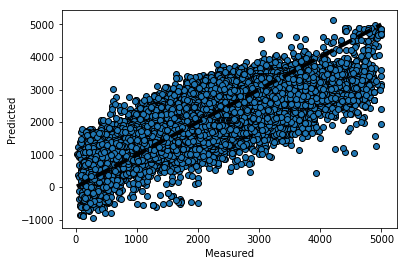

In [49]:
model_train_test_error_CrossValPredict(
    linear_model.LinearRegression(), 
    data, 
    feature_cols, predecir)

Metrics.R2: 0.5234733246000136


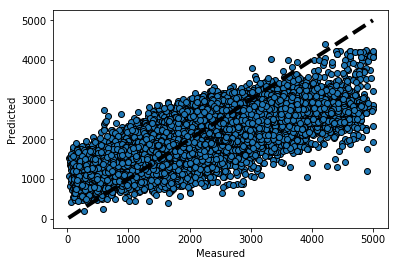

In [56]:
model_train_test_error_CrossValPredict(
    linear_model.Ridge(normalize=True), 
    data, 
    feature_cols, predecir)

Metrics.R2: 0.18047251912900752


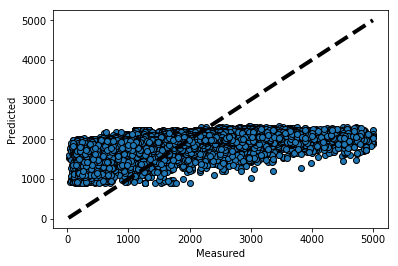

In [57]:
model_train_test_error_CrossValPredict(
    linear_model.Lasso(normalize=True), 
    data, 
    feature_cols, predecir)

Metrics.R2: -0.00554347821338208


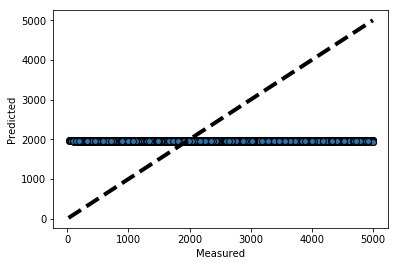

In [58]:
model_train_test_error_CrossValPredict(
    linear_model.ElasticNet(normalize=True), 
    data, 
    feature_cols, predecir)